# Session 3: Fitting Polynomials

## Grace Hymas 15th January 2018

_Script author: louise.dash@ucl.ac.uk    
Updated: 05/01/2018_

<div class="alert alert-success"> <p>*  **Intended learning outcomes:** * </p>
By the end of this session, you should be able to:
<ul>
<li> Use Python to fit a set of data to a polynomial; </li>
<li> To evaluate the goodness of fit using the matrix of covariance and Chi^2</li>
<li> Fit the residuals to a Gaussian. </li>
</div>

## Why fit to a polynomial?

In physics we often meet an experimental relation between variables which is difficult to describe mathematically. This may either be because the theoretical equation which describes the observed behaviour is difficult to solve, or because the situation is complicated by several ill-defined factors and it is difficult to derive any theoretical equation which can describe it properly. However, we can still measure the dependence between the variables experimentally and we would like to have some means of predicting this dependence. In this kind of situation it is convenient to fit an equation to our experimental data. We can then use the fitted equation to interpolate, i.e. to calculate the expected value of a variable between our measured data points, and to extrapolate, i.e. to calculate the expected value beyond the range of our measured data points. This procedure is often called “parameterizing” the relationship.

In principle we could use any form of equation to fit a set of measured data, but if we have no theoretical basis for fitting a particular type of curve it is often simplest and easiest to fit a polynomial. The order of the polynomial and the coefficients of each term in the fitted equation are called the “parameters” of our fit.

In this session we will look at how to fit polynomials with numpy, using experiment E5 as an example. If you are taking PHAS2441 you will be doing this experiment yourself in the second half of term. The experiment involves calibrating a temperature sensor by measuring its output voltage over a range of temperature. A polynomial equation is then fitted to the experimental results and this calibration equation is later input into a programmable chip so that the sensor can operate as a digital thermometer.

## Using numpy to fit a polynomial to a dataset

The first thing we need to do is import the modules we'll need. Enter these in the code cell below

In [1]:
import numpy as np                #importing necessary modules with usefully concise names
import matplotlib.pyplot as plt
%matplotlib inline 

Now we should load our data file, which is called "studentdataE5.txt". This data file contains two columns, the first is the temperature in Celsius, the second the measured voltage (V). 


<div class='alert alert-success'> 
In the code cell below:
<ul>
<li> Load the data file using np.loadtxt, and unpack it into two arrays called `temp` and `voltage`. </li>
<li> Plot it on a (labelled!) graph, using data points only (no line). </li>
</ul>

</div>

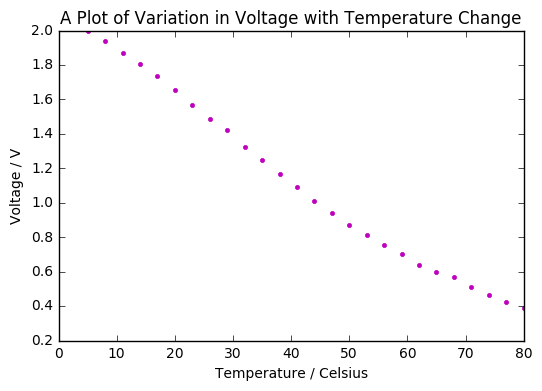

In [2]:
temp, voltage = np.loadtxt("studentdataE5.txt", unpack=True)    # unpacking data into separate arrays
plt.plot(temp, voltage, 'm.')                                   # plotting the graph with temperature as x and voltage as y
plt.xlabel('Temperature / Celsius')                             # plotting relevant axes titles
plt.ylabel('Voltage / V')  
plt.title('A Plot of Variation in Voltage with Temperature Change')    

### Numpy's polyfit function(s)

Fortunately, we can get numpy to do all the hard work of fitting for us, by using the * **polyfit** * function. The documentation for this is here: http://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html - have a quick look at this before proceeding.

The cell below shows an example usage of np.polyfit. To run it, change "temp" and "voltage" to whatever you are using as the relevant variable names.

In [3]:
degree = 2                                               # degree of polynomial we want to fit to
p = np.polyfit(temp,voltage,degree)                      # fitting a polynomial to specified data
print ("The fitted polynomial coefficients are", p)      

The fitted polynomial coefficients are [  1.06532357e-04  -3.15934839e-02   2.21148238e+00]


** * IMPORTANT NOTE: * ** Numpy actually has two versions of polyfit. `numpy.polyfit`, and  `numpy.polynomial.polynomial.polyfit`. They are almost identical, and are used in the same way. But look at the one crucial difference:

In [4]:
p = np.polyfit(temp,voltage,degree)                                             # fitting the polynomial again, returns coefficients highest power first
print ("np.polyfit returns the coefficients as", p)                        
pp = np.polynomial.polynomial.polyfit(temp,voltage,degree)                      # fitting polynomial, returns coefficients lowest power first
print ("np.polynomial.polynomial.polyfit returns the coefficients as", pp)

np.polyfit returns the coefficients as [  1.06532357e-04  -3.15934839e-02   2.21148238e+00]
np.polynomial.polynomial.polyfit returns the coefficients as [  2.21148238e+00  -3.15934839e-02   1.06532357e-04]


`numpy.polyfit` (our `np.polyfit`) returns the coefficients with the highest power first, but `numpy.polynomial.polynomial.polyfit` returns the lowest power first. This is daft.
  
However, it is an important reminder of *why* we import our modules with named abbreviations - it makes it clear which version of which module function we're using!

### Plotting fitted polynomials

Now we have our polynomial coefficients, we probably want to plot this polynomial to see how good the fit is. We could construct an expresssion for this from the elements of p, but there's a much easier way to do this with the numpy function poly1d (http://docs.scipy.org/doc/numpy/reference/generated/numpy.poly1d.html ), which will convert the array of polynomial coefficients $p$ into a function that we can call to generate the value of the polynomial for a given value of $x$. The following code cell does this by using np.poly1d to create a _function_ called "line":

In [5]:
line = np.poly1d(p)    # generates polynomial as a function

<div class='alert alert-success'> 

Now you need to:
<ul>
<li> Generate an array of x-values to fit the data to </li>
<li> Use the "line" function we just created to generate a corresponding array of y-values.</li>
<li> Plot the original data (as points) and the fitted line (as a line) on a labelled graph.</li>
</ul>
Do this in the cell below.
</div>

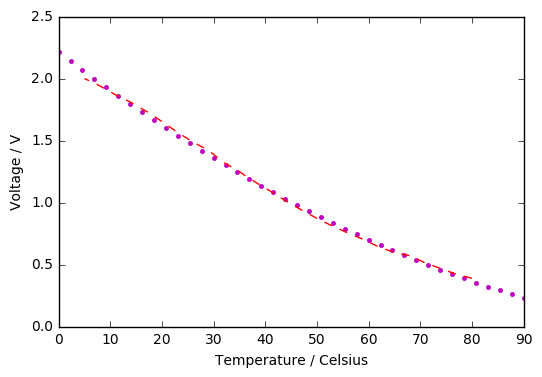

In [6]:
x = np.linspace(0,90,40)                                     # generating x values
y = line(x)                                                  # generating corresponding y values
plt.plot(x,y,'m.', label="Fitted polynomial")                # plotting fitted polynomial
plt.plot(temp, voltage, 'r--', label="Experimental data")    # plotting actual values
plt.xlabel('Temperature / Celsius')                          # plotting labels
plt.ylabel('Voltage / V')  

At first glance, this second-order polynomial looks okayish (or it should do if you've done it right!) - but with definite room for improvement.

But how good is the fit really?

## Goodness of fit (1) - calculating the errors on the coefficients and the matrix of covariance.

We'll recalculate, this time with an important addition to the polyfit call - we'll ask it to also calculate the matrix of covariance.

(A Python aside: In the cell below, there's also a line that limits the number of decimal places that are displayed when we print a numpy array. This is just for convenience - compare this with the arrays printed out at full precision above: which do you find easier to read? You can change the number of decimal points displayed to whatever you want. Note that this will affect _all_ arrays printed after this line is run, but won't affect the formatting of any other numbers, including array elements. See https://docs.scipy.org/doc/numpy/reference/generated/numpy.set_printoptions.html for full documentation of this function - we will be using it again in other sessions.)

In [7]:
# It's useful to limit the number of dp displayed for arrays - see above
np.set_printoptions(precision=4) # 4 dec.places

# recalculating the polynomial
degree = 2 # degree of polynomial we want to fit to
p, v = np.polyfit(temp,voltage,degree,cov=True)                   # fitting polynomial
print("The fitted polynomial coefficients are:\n", p)             # printing values
print("The matrix of covariance is:\n", v)

The fitted polynomial coefficients are:
 [  1.0653e-04  -3.1593e-02   2.2115e+00]
The matrix of covariance is:
 [[  1.1925e-10  -1.0136e-08   1.5502e-07]
 [ -1.0136e-08   9.0966e-07  -1.5220e-05]
 [  1.5502e-07  -1.5220e-05   3.1272e-04]]


#### What is the matrix of covariance?

**The quick answer:** The matrix of covariance allows us to calculate the errors on our fitted parameters. For $n$ parameters, the matrix of covariance is an $n \times n$ matrix, whose diagonal elements are the *square* of the uncertainties of the fitted parameters. The off-diagonal elements give the level of correlation between the uncertainties in the parameters - we won't use them here.

**The long (and more complete answer)** is given in sections 7.2-7.4 of [Hughes and Hase](https://www.dawsonera.com/guard/protected/dawson.jsp?name=https://shib-idp.ucl.ac.uk/shibboleth&dest=http://www.dawsonera.com/depp/reader/protected/external/AbstractView/S9780191576560).




When the cell below is complete, it will output the order of each coefficient, the corresponding coefficient and its error, with appropriate text strings.

Look at how we do this:

1. This is most easily done using a loop over the elements of `p`. For example, the length of an array `p` is given by `len(p)` or `np.size(p)`. The structure  `for i in range(np.size(p)):` sets up a loop that will iterate the same number of times as there are elements in the array.
2. Remember that `np.polyfit` gives the coefficients largest-order first. So for a loop with increasing index i, the order of the coefficient `p(i)` will be given by `len(p)-i-1`.


<div class='alert alert-success'>
You will need to complete the final line of this cell to calculate the error of each coefficient.

You'll probably want to use `np.diag` to extract the diagonal elements of the matrix of covariance, in the form of a 1d array. You can find out more about this numpy function here: http://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html <div>


In [8]:
for i in range(np.size(p)):
    print("coefficient order x^", len(p)-i-1, " is ", p[i], " with error ", np.diag(v)[i]**0.5)    
    # - 1 since two degrees for the fit results in three coefficients
    # p is polynomial fitted earlier
    # coviarience matrix used for error as only diagonal elements are uncertainties

coefficient order x^ 2  is  0.000106532356532  with error  1.09201314668e-05
coefficient order x^ 1  is  -0.0315934839235  with error  0.000953759556164
coefficient order x^ 0  is  2.21148237688  with error  0.0176838708696


#### An important caveat about the interpretation of these errors

When doing calculations like this it's important to understand how the mathematics of the calculations relates to the reality of the experiment and the data. In this case we can see that the off-diagonal elements of `v` are clearly non-zero, and hence there is a significant correlation between the polynomial coefficients.

The diagonal elements of the matrix of covariance can be used to find the uncertainty of a coefficient *IF THAT COEFFICIENT ALONE IS THE REQUIRED RESULT OF THE EXPERIMENT*; but when calculating any values based on the full set of coefficients (e.g. the value of the fit for a particular abscissa value) this can give a gross overestimate.  In advanced methods the full matrix is used, but at the undergraduate level some simplified approximation should be employed, such as taking just the covariance of the zero order coefficient.

You should bear this in mind later in the term when you are doing experiment E5 yourselves. For the moment, however, as we are just concerning ourselves with the polynomial fitting itself, we'll continue to take the errors of the coefficients from the matrix of covariance.

This issue will be explored in more detail next year in course PHAS3440 (Lab 3).

## Goodness of fit (2) - calculating the residuals and $\chi^2$

Remember that the residuals are defined as the vertical distance between each of the data points and the fitted line. If the fitted line passes exactly through one of the data points the residual for this point is zero. We can see intuitively that if we have a "good" fit the residual values will be small. However, we have to remember that our experimental data points are subject to random errors and so we should expect the values of the residuals to be randomly distributed about zero. If we find that all the residuals are exactly zero we should start to suspect that our line is "over-fitted". This means it fits our initial data exactly, but if we take any more measurements (subject of course to the same random errors) the line will not fit them and therefore cannot be used to predict their values in advance. So for a useful parameterization of our dataset we need a fit which is "good" but not "too good". The chi-squared test is a statistical tool which can help us find the sort of fit we need. 

*Hint: For a guide that will enable you to use a numerical value of $\chi^2$ to decide if your fit is "good", "too good", or "not good", look at the text box on page 107 of [Hughes and Hase](https://www.dawsonera.com/guard/protected/dawson.jsp?name=https://shib-idp.ucl.ac.uk/shibboleth&dest=http://www.dawsonera.com/depp/reader/protected/external/AbstractView/S9780191576560).*


The numpy polyfit function calculates the residuals for us. We can also obtain more data from polyfit by setting full=True (but note that this is mutually exclusive with cov=True, you can only have one or the other). Again from the np.polyfit documentation:

       "residuals, rank, singular_values, rcond : present only if full = True
            Residuals of the least-squares fit, the effective rank of the scaled Vandermonde coefficient matrix, 
            its singular values, and the specified value of rcond. For more details, see linalg.lstsq."
            
            
(http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html#numpy.linalg.lstsq)

Let's look at what this gives us:
      

In [9]:
p, residuals, rank, singular_values, rcond = np.polyfit(temp,voltage,degree,full=True)     

print("p is:", p)
print("residuals array is:", residuals)
print("rank is:", rank)
print("singular_values is:", singular_values)
print("rcond is:", rcond)

p is: [  1.0653e-04  -3.1593e-02   2.2115e+00]
residuals array is: [ 0.0133]
rank is: 3
singular_values is: [ 1.6569  0.4974  0.0845]
rcond is: 5.77315972805e-15


Note that here "residuals" gives us the *sum* of the square of the residuals, not the individual residuals themselves, which is normally what we're interested in. But it's easy to calculate them, so normally it's more useful to have `cov=True` than `full=True`.

To calculate the residuals, we just remember that the residuals are the vertical distance between the data point and the fitted line. 


<div class="alert alert-success">
Use the cell below to calculate and print out:
<ul>
<li> the residuals; </li> 
<li>  the squares of the residuals; and</li> 
<li>  the sum of the squares of the residuals.</li> 
</ul>
</div>



In [18]:
line = np.poly1d(p)                          # generates polynomial as function
residuals = line(temp) - voltage             # finding residuals
print(residuals)                             # printing necessary outputs please note must be printed in order as printing after later functions confuses defined variables
print((np.square(residuals)) )
print(np.sum((np.square(residuals))))

[-0.0015  0.007   0.0016 -0.0018 -0.0174  0.0023  0.0069 -0.0023  0.001
  0.0041  0.0049  0.0036  0.0019 -0.0035 -0.0018 -0.0046  0.0026 -0.013
  0.002   0.0066  0.0007 -0.0027  0.0002  0.008   0.0002 -0.0047]
[  2.3397e-06   4.8376e-05   2.5605e-06   3.0973e-06   3.0270e-04
   5.3054e-06   4.6982e-05   5.4960e-06   9.9961e-07   1.6570e-05
   2.4437e-05   1.2851e-05   3.4345e-06   1.2263e-05   3.3836e-06
   2.1409e-05   6.5513e-06   1.6808e-04   4.0304e-06   4.3220e-05
   5.2557e-07   7.0699e-06   3.8061e-08   6.3219e-05   2.7026e-08
   2.2259e-05]
0.000827222727797


Check that your result for the sum of the squares of the residuals is the same as the same as the "residuals" generated by full=True.

To take account of the random experimental errors affecting our data we can also divide the residuals by the error in the dependent variable (here the voltage is our "y" value), which for this experiment was estimated by the student as 0.006 V for all values (if the error is different for each measurement, we can just have a 1D-array for this instead of a single number). 



<div class="alert alert-success">
The student measured the error in the voltage to be 0.006 V for all the measured values.
<br>
In the cell below, repeat your calculations above, but using the residuals divided by the y-error rather than the residuals alone:
</div>

In [11]:
residuals = line(temp) - voltage              # refinding residuals, not really necessary
print(residuals/0.006)                        # scaling residuals
print(((residuals/0.006)**2))                 # finding asked values and printing
print(np.sum((residuals/0.006)**2))
sumresid = (np.sum((residuals/0.006)**2))

[-3.8649 -1.7643 -1.6774 -1.1042 -2.5448  1.8342  3.5328  2.7177  3.7221
  4.3795  4.3565  3.6531  2.6026  0.7051 -0.2062 -1.9646 -2.07   -5.8558
 -4.3221 -4.1354 -5.1291 -4.9698 -2.8243  1.3074  4.2588  9.363 ]
[  1.4937e+01   3.1126e+00   2.8136e+00   1.2193e+00   6.4761e+00
   3.3642e+00   1.2481e+01   7.3857e+00   1.3854e+01   1.9180e+01
   1.8979e+01   1.3345e+01   6.7736e+00   4.9713e-01   4.2525e-02
   3.8595e+00   4.2849e+00   3.4291e+01   1.8680e+01   1.7101e+01
   2.6307e+01   2.4699e+01   7.9769e+00   1.7093e+00   1.8137e+01
   8.7667e+01]
369.174278931


Dividing this by the number of degrees of freedom will give us the reduced $\chi^2$. The number of degrees of freedom is defined as the total number of datapoints minus the number of coefficients or fitting parameters in the fitted equation.


<div class="alert alert-success">
In the cell below, calculate and output the number of degrees of freedom and the reduced $\chi^2$.
</div>

In [12]:
dof = np.size(temp) - degree - 1                         # - 1 since two degrees for the fit results in three coefficients
print("The number of degrees of freedom is:", dof) 
print("The reduced chi-squared value is:", (np.sum((residuals/0.006)**2)/ dof))

The number of degrees of freedom is: 23
The reduced chi-squared value is: 16.0510556057


The reduced $\chi^2$ is useful as it gives us a single number with which we can compare the goodness of fit of different polynomials.

Now we have everything in place, let's try comparing different polynomials. 

<div class="alert alert-success">
Write code in the cell below that will calculate the best fit polynomials of order 1,2,3,4,5 and 6. For each of these:<ul>

<li>  Print out the coefficients, with their order, and error </li>
<li>  Calculate and output the number of degrees of freedom and the reduced $\chi^2$ </li>
    </ul>
</div>

Hints: 
* the most efficient way of doing this is with a loop structure
* The residuals are the vertical distance between the fitted line and the data point - so you'll need to recalculate the residuals for each fitted line
* The `line` function we generated was specific to those values of `p`. So each time the array of polynomial coefficients `p` changes, you'll also need to redefine this function.

In [19]:
for i in range(1,7):
    coefficients,v = np.polyfit(temp,voltage,i,cov=True)                 # generating polynomial
    print ("The fitted polynomial coefficients are", coefficients)
    line1 = np.poly1d(coefficients)                                      # function generates values
    
    y = line1(temp) # generates fitted y-values for each x-value

    # extract coefficients and errors from matrix of covariance
    for i in range(np.size(coefficients)):
        order = len(coefficients)-i-1
        print("coefficient order x^", order, " is ", coefficients[i], " with error ", np.diag(v)[i]**0.5)
    
    # calculates the sum of the residuals
    sumresid = 0
    
    # finding total residuals
    for j in range(np.size(temp)):
        yresidual = y[j]-voltage[j]
        sumresid += (yresidual/0.006)**2
       
    
    # outputting all values
    print("The sum of the squares of the residuals is: ", sumresid)
    
    dof = np.size(temp) - i - 1# - 1 since two degrees for the fit results in three coefficients
    print(dof)
    print("For a polynomial of degree",i ,"the reduced chi-squared value is:", sumresid / dof)
    print()

The fitted polynomial coefficients are [-0.0225  2.073 ]
coefficient order x^ 1  is  -0.0225382336182  with error  0.000503879579881
coefficient order x^ 0  is  2.07299031339  with error  0.0242307930996
The sum of the squares of the residuals is:  2042.26493827
24
For a polynomial of degree 1 the reduced chi-squared value is: 85.094372428

The fitted polynomial coefficients are [  1.0653e-04  -3.1593e-02   2.2115e+00]
coefficient order x^ 2  is  0.000106532356532  with error  1.09201314668e-05
coefficient order x^ 1  is  -0.0315934839235  with error  0.000953759556164
coefficient order x^ 0  is  2.21148237688  with error  0.0176838708696
The sum of the squares of the residuals is:  369.174278931
23
For a polynomial of degree 2 the reduced chi-squared value is: 16.0510556057

The fitted polynomial coefficients are [  2.2157e-06  -1.7597e-04  -2.1602e-02   2.1270e+00]
coefficient order x^ 3  is  2.21566962641e-06  with error  2.81071505362e-07
coefficient order x^ 2  is  -0.000175965520

<div class="alert alert-success"> Which order of fitted polynomial would you use to parameterize the relationship between voltage and temperature for this sensor? <br> 
Give the reasons for your choice in a text cell. <br> Then plot the fitted line for the polynomial you think best represents the data, together with the original data, on a labelled graph</div>

We want the $\chi^2$ value to be near to one (as this means it is closest to expected vaalues), with minimal uncertainty in our coefficeints. We can see above, these two constraints are best satisfied when we use polynomials of degree 6, which is plotted below.

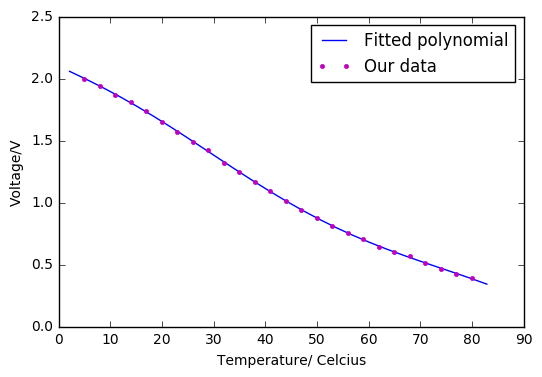

In [24]:
p = np.polyfit(temp,voltage,6)                # generating array of parameters
line = np.poly1d(p)                           # puts parametes into polynomial
x_max = np.max(temp)                          # generating values to plot
x_min = np.min(temp)
interval = (x_max - x_min)/len(temp)

x_plot = np.linspace(x_min-interval,x_max+interval,len(temp))     # full generated plot values
y_plot = line(x_plot)

plt.plot(x_plot,y_plot, 'b-', label="Fitted polynomial")
plt.plot(temp, voltage, 'm.', label="Our data")
plt.xlabel('Temperature/ Celcius')
plt.ylabel('Voltage/V')
plt.legend(loc='best')

## Fitting the residuals to a Gaussian

It would be interesting to have a closer look at the residuals. In theory, they should follow a Gaussian (normal) distribution. Do they?

Fit the residuals to a Gaussian using scipy.stats (following the same process as we did in session 2), and plot them as a histogram together with the fitted Gaussian.

<div class="alert alert-success">Do you think that these residuals match the expected distribution?
What relation do you notice between the the standard deviation of the residuals and the experimental error on the voltage reading estimated by the student who did this experiment? Explain in a text cell.</div>

The fitted polynomial coefficients are [  1.2840e-11  -3.9286e-09   4.0488e-07  -1.4272e-05   1.1204e-05
  -1.9440e-02   2.0991e+00]
Fitted Gaussian: 
 Mean value  -3.0744637605e-16 with standard deviation 0.00514330069151


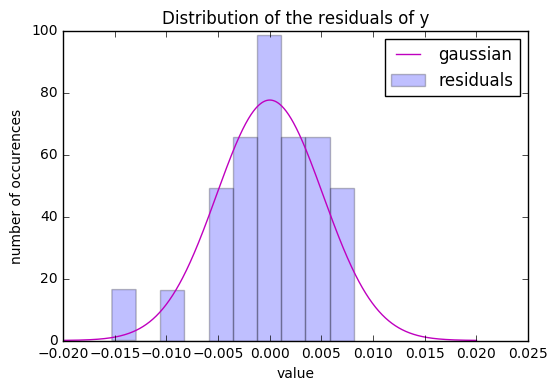

In [25]:
import scipy.stats as stats    # usefully short named import

residuals = line(temp) - voltage                         # finding residuals
p,v = np.polyfit(temp,voltage,6,cov=True)                # generating parameters
print ("The fitted polynomial coefficients are", p)
line = np.poly1d(p)                                      # putting parameters into polynomial

plt.hist(residuals,normed=True,alpha=0.25,label="residuals")      # plotting histogram and labels
plt.xlabel("value")
plt.ylabel("number of occurences")

# fits the residuals to a gaussian
x0, sigma = stats.norm.fit(residuals)                                              # fits normal distribution to data
print ("Fitted Gaussian: \n Mean value ", x0, "with standard deviation", sigma)   

# plot the gaussian
x = np.linspace(-0.02,0.02,1000)                     # generating x values
gaussian = stats.norm.pdf(x,x0,sigma)                # fitting normal distribution to data
plt.plot(x,gaussian,'m-', label="gaussian")          # plotting data with legend and title
plt.legend(loc='best'),
plt.title("Distribution of the residuals of y")

The residuals do roughly follow a Gaussian distribution, but it does have a slightly negative skew. The Gaussian has width approximately equal to the experimental uncertainty which seems valid as the majority of the values of a given measurement should fall within range of this uncertainty.

### What's coming next

In this session we've seen how to fit data in a general case when we don't already know from a theoretical model what function we want to fit to. In the next session, we'll be looking at how to to use Python fit a line when we know what function we want to fit the data to.